In [29]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import defaultdict, Counter
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# COCO tools
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from pycocotools.cocoeval import COCOeval

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
Memory: 25.20 GB


In [30]:
# from google.colab import drive
# drive.mount('/content/drive')

In [31]:
import os

class Config:
    DATA_DIR = './RMDS_Segmentation_Assignment'

    # Train paths
    TRAIN_DIR = os.path.join(DATA_DIR, 'train-300/data')
    TRAIN_JSON = os.path.join(DATA_DIR, 'train-300/labels.json')

    # Validation paths
    VAL_DIR = os.path.join(DATA_DIR, 'validation-300/data')
    VAL_JSON = os.path.join(DATA_DIR, 'validation-300/labels.json')

    # Test folder (images directly here)
    TEST_DIR = os.path.join(DATA_DIR, 'test-30')
    TEST_JSON = os.path.join(DATA_DIR, 'test-30/labels.json')  # if exists, else ignore

    # Classes
    CLASSES = ['__background__', 'person', 'cat', 'sports ball', 'book']
    NUM_CLASSES = len(CLASSES)

    COCO_TO_CLASS = {
        1: 1,
        17: 2,
        37: 3,
        84: 4
    }

    BATCH_SIZE = 4
    NUM_EPOCHS = 30
    LEARNING_RATE = 0.002
    MOMENTUM = 0.9
    WEIGHT_DECAY = 0.0005
    STEP_SIZE = 10
    GAMMA = 0.3

    IMAGE_SIZE = 640
    IOU_THRESHOLD = 0.5


config = Config()

# Verify paths
for path in [config.TRAIN_DIR, config.VAL_DIR, config.TEST_DIR]:
    print(path, "→", "FOUND" if os.path.exists(path) else "MISSING")


./RMDS_Segmentation_Assignment/train-300/data → FOUND
./RMDS_Segmentation_Assignment/validation-300/data → FOUND
./RMDS_Segmentation_Assignment/test-30 → FOUND


In [32]:
"""
Functions for Exploratory Data Analysis
"""

def load_coco_annotations(json_path):
    """Load COCO format annotations"""
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

def analyze_dataset(json_path, dataset_name="Dataset"):
    """Comprehensive dataset analysis"""
    coco_data = load_coco_annotations(json_path)

    # Basic statistics
    num_images = len(coco_data['images'])
    num_annotations = len(coco_data['annotations'])
    num_categories = len(coco_data['categories'])

    print(f"\n{'='*60}")
    print(f"{dataset_name} Statistics")
    print(f"{'='*60}")
    print(f"Total Images: {num_images}")
    print(f"Total Annotations: {num_annotations}")
    print(f"Total Categories: {num_categories}")
    print(f"Average annotations per image: {num_annotations/num_images:.2f}")

    # Category distribution
    category_counts = defaultdict(int)
    for ann in coco_data['annotations']:
        category_counts[ann['category_id']] += 1

    # Map to our classes
    class_counts = defaultdict(int)
    for cat_id, count in category_counts.items():
        if cat_id in config.COCO_TO_CLASS:
            class_id = config.COCO_TO_CLASS[cat_id]
            class_name = config.CLASSES[class_id]
            class_counts[class_name] = count

    print(f"\nClass Distribution:")
    print(f"{'-'*60}")
    for class_name, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{class_name:15s}: {count:4d} instances")

    # Image size analysis
    widths = [img['width'] for img in coco_data['images']]
    heights = [img['height'] for img in coco_data['images']]

    print(f"\nImage Dimensions:")
    print(f"{'-'*60}")
    print(f"Width  - Min: {min(widths):4d}, Max: {max(widths):4d}, Mean: {np.mean(widths):.1f}")
    print(f"Height - Min: {min(heights):4d}, Max: {max(heights):4d}, Mean: {np.mean(heights):.1f}")

    # Annotation area analysis
    areas = [ann['area'] for ann in coco_data['annotations']]
    print(f"\nAnnotation Areas:")
    print(f"{'-'*60}")
    print(f"Min: {min(areas):.1f}, Max: {max(areas):.1f}")
    print(f"Mean: {np.mean(areas):.1f}, Median: {np.median(areas):.1f}")

    return coco_data, class_counts

# Analyze both datasets
train_data, train_class_counts = analyze_dataset(config.TRAIN_JSON, "Training Set")
val_data, val_class_counts = analyze_dataset(config.VAL_JSON, "Validation Set")


Training Set Statistics
Total Images: 300
Total Annotations: 2715
Total Categories: 80
Average annotations per image: 9.05

Class Distribution:
------------------------------------------------------------
person         : 1137 instances
book           :  128 instances
cat            :   27 instances
sports ball    :   18 instances

Image Dimensions:
------------------------------------------------------------
Width  - Min:  333, Max:  640, Mean: 579.0
Height - Min:  281, Max:  640, Mean: 477.4

Annotation Areas:
------------------------------------------------------------
Min: 2.3, Max: 299325.2
Mean: 9968.2, Median: 1306.2

Validation Set Statistics
Total Images: 300
Total Annotations: 2686
Total Categories: 80
Average annotations per image: 8.95

Class Distribution:
------------------------------------------------------------
person         : 1026 instances
book           :  129 instances
sports ball    :   36 instances
cat            :   22 instances

Image Dimensions:
------------

Generating visualizations...


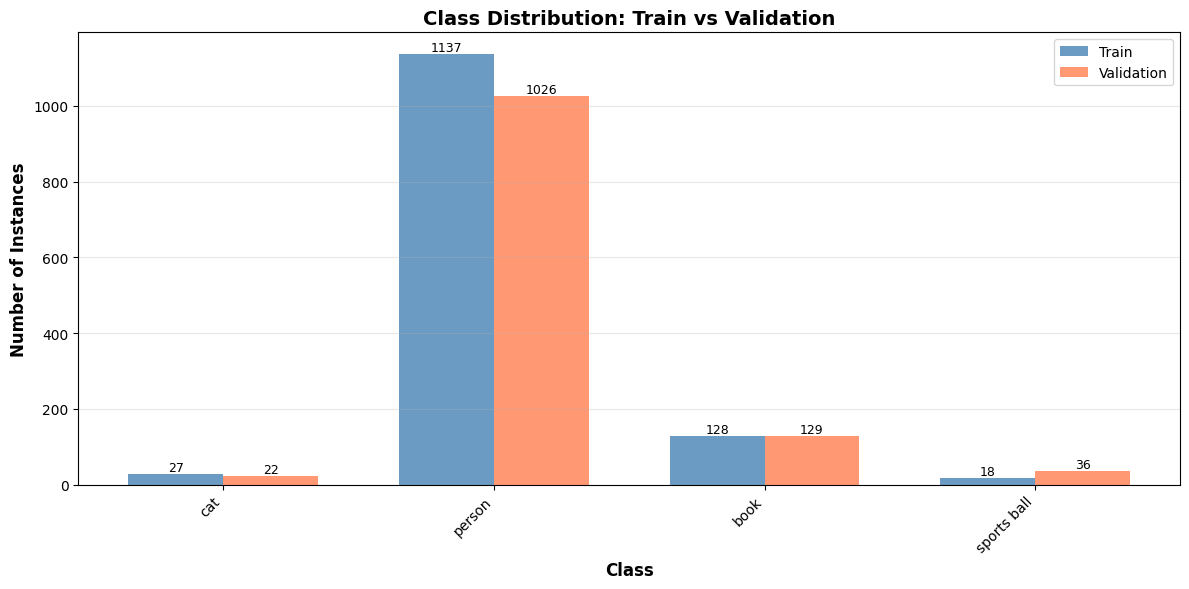

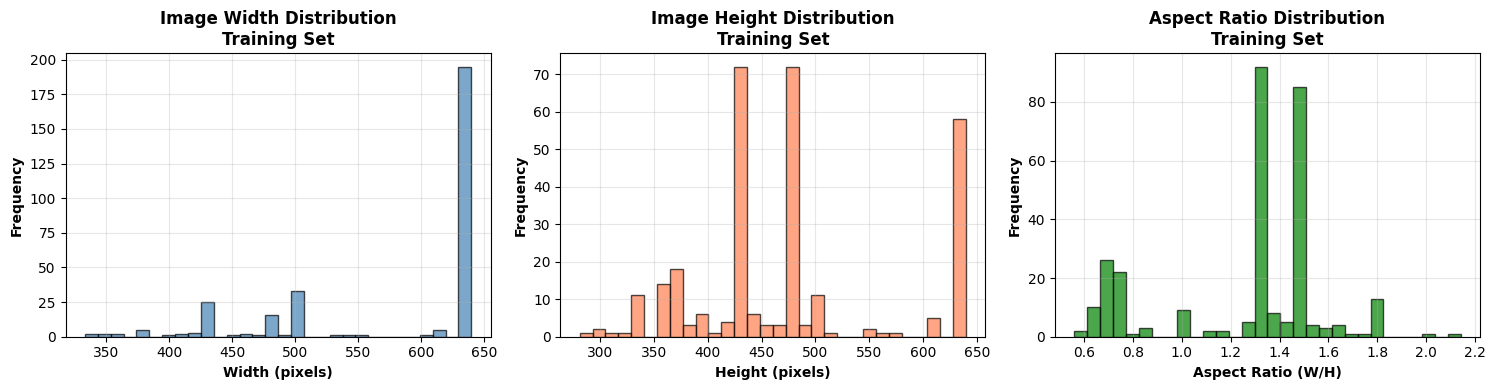

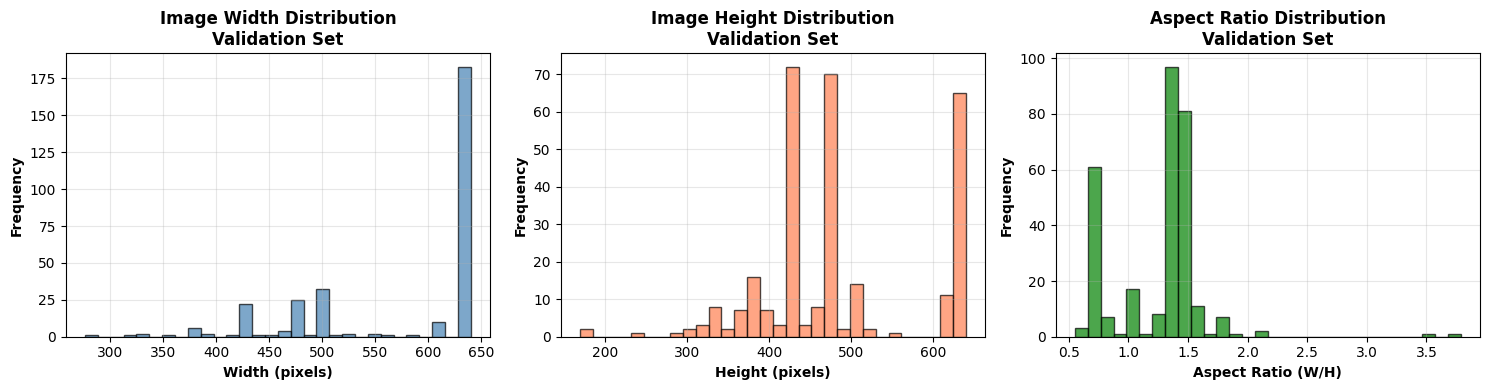

Loading annotations from: ./RMDS_Segmentation_Assignment/train-300/labels.json
Loading images from: ./RMDS_Segmentation_Assignment/train-300/data
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Found 6 images to visualize


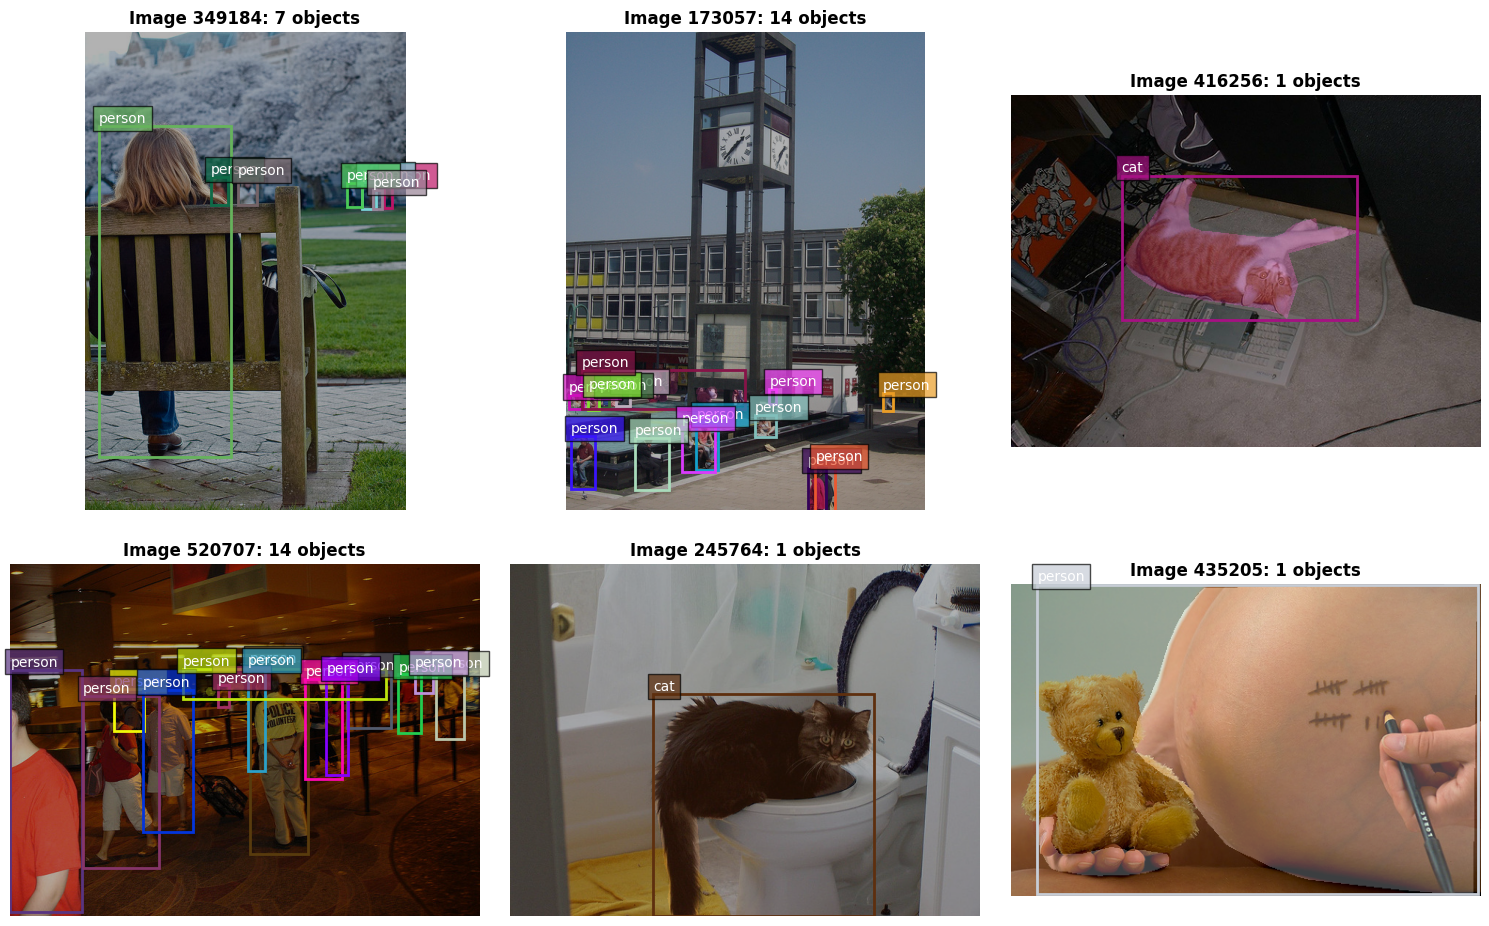

Successfully visualized 6 images


In [33]:
"""
Visualization functions for EDA - FIXED VERSION
"""

def plot_class_distribution(train_counts, val_counts):
    """Plot class distribution comparison"""
    classes = list(train_counts.keys())
    train_values = [train_counts[c] for c in classes]
    val_values = [val_counts[c] for c in classes]

    x = np.arange(len(classes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, train_values, width, label='Train', alpha=0.8, color='steelblue')
    bars2 = ax.bar(x + width/2, val_values, width, label='Validation', alpha=0.8, color='coral')

    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
    ax.set_title('Class Distribution: Train vs Validation', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_image_dimensions(coco_data, dataset_name):
    """Plot image dimension distributions"""
    widths = [img['width'] for img in coco_data['images']]
    heights = [img['height'] for img in coco_data['images']]
    aspect_ratios = [w/h for w, h in zip(widths, heights)]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Width distribution
    axes[0].hist(widths, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Width (pixels)', fontweight='bold')
    axes[0].set_ylabel('Frequency', fontweight='bold')
    axes[0].set_title(f'Image Width Distribution\n{dataset_name}', fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Height distribution
    axes[1].hist(heights, bins=30, color='coral', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Height (pixels)', fontweight='bold')
    axes[1].set_ylabel('Frequency', fontweight='bold')
    axes[1].set_title(f'Image Height Distribution\n{dataset_name}', fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Aspect ratio distribution
    axes[2].hist(aspect_ratios, bins=30, color='green', alpha=0.7, edgecolor='black')
    axes[2].set_xlabel('Aspect Ratio (W/H)', fontweight='bold')
    axes[2].set_ylabel('Frequency', fontweight='bold')
    axes[2].set_title(f'Aspect Ratio Distribution\n{dataset_name}', fontweight='bold')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_sample_annotations(json_path, image_dir, num_samples=6):
    """Visualize sample images with annotations - FIXED VERSION"""

    # Verify paths exist
    if not os.path.exists(json_path):
        print(f"✗ JSON file not found: {json_path}")
        return
    if not os.path.exists(image_dir):
        print(f"✗ Image directory not found: {image_dir}")
        return

    print(f"Loading annotations from: {json_path}")
    print(f"Loading images from: {image_dir}")

    coco = COCO(json_path)

    # Get image IDs for our classes only
    valid_cat_ids = list(config.COCO_TO_CLASS.keys())
    img_ids = []
    for cat_id in valid_cat_ids:
        img_ids.extend(coco.getImgIds(catIds=[cat_id]))
    img_ids = list(set(img_ids))[:num_samples]

    if len(img_ids) == 0:
        print("✗ No images found with target classes!")
        return

    print(f"Found {len(img_ids)} images to visualize")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    successful_plots = 0

    for idx, img_id in enumerate(img_ids):
        if idx >= num_samples:
            break

        img_info = coco.loadImgs(img_id)[0]
        img_filename = img_info['file_name']
        img_path = os.path.join(image_dir, img_filename)

        # Check if image exists
        if not os.path.exists(img_path):
            print(f"✗ Image not found: {img_path}")
            # Try without subdirectory
            img_path = os.path.join(image_dir, os.path.basename(img_filename))
            if not os.path.exists(img_path):
                print(f"✗ Also tried: {img_path}")
                axes[idx].text(0.5, 0.5, f'Image {img_id}\nNOT FOUND',
                             ha='center', va='center', fontsize=12)
                axes[idx].axis('off')
                continue

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"✗ Failed to load: {img_path}")
            axes[idx].text(0.5, 0.5, f'Image {img_id}\nFAILED TO LOAD',
                         ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        # Filter annotations for our classes
        anns = [ann for ann in anns if ann['category_id'] in config.COCO_TO_CLASS]

        axes[idx].imshow(img)

        # Draw masks and boxes
        for ann in anns:
            # Get class name
            cat_id = ann['category_id']
            class_id = config.COCO_TO_CLASS[cat_id]
            class_name = config.CLASSES[class_id]

            # Draw mask
            if 'segmentation' in ann:
                try:
                    mask = coco.annToMask(ann)
                    color_mask = np.zeros_like(img)
                    color = np.random.randint(0, 255, 3).tolist()
                    color_mask[mask == 1] = color
                    img_masked = cv2.addWeighted(img, 0.7, color_mask, 0.3, 0)
                    axes[idx].imshow(img_masked)
                except:
                    pass  # Skip if mask conversion fails

            # Draw bounding box
            bbox = ann['bbox']
            x, y, w, h = bbox
            rect = plt.Rectangle((x, y), w, h, fill=False,
                                edgecolor=np.array(color)/255, linewidth=2)
            axes[idx].add_patch(rect)
            axes[idx].text(x, y-5, class_name,
                          color='white', fontsize=10,
                          bbox=dict(facecolor=np.array(color)/255, alpha=0.7))

        axes[idx].axis('off')
        axes[idx].set_title(f"Image {img_id}: {len(anns)} objects", fontweight='bold')
        successful_plots += 1

    # Hide unused subplots
    for idx in range(successful_plots, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('sample_annotations.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Successfully visualized {successful_plots} images")

# Generate visualizations
print("Generating visualizations...")
plot_class_distribution(train_class_counts, val_class_counts)
plot_image_dimensions(train_data, "Training Set")
plot_image_dimensions(val_data, "Validation Set")
visualize_sample_annotations(config.TRAIN_JSON, config.TRAIN_DIR, num_samples=6)

In [34]:


class COCOSegmentationDataset(Dataset):
    def __init__(self, image_dir, json_path, transforms=None, config=None):
        """
        Args:
            image_dir: Directory containing images
            json_path: Path to COCO format JSON
            transforms: Albumentations transforms
            config: Configuration object
        """
        self.image_dir = image_dir
        self.coco = COCO(json_path)
        self.transforms = transforms
        self.config = config if config else Config()

        # Get all image IDs that contain our classes
        valid_cat_ids = list(self.config.COCO_TO_CLASS.keys())
        self.img_ids = []
        for cat_id in valid_cat_ids:
            self.img_ids.extend(self.coco.getImgIds(catIds=[cat_id]))
        self.img_ids = list(set(self.img_ids))

        print(f"Loaded {len(self.img_ids)} images with target classes")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        # Load image
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Filter for our classes only
        anns = [ann for ann in anns if ann['category_id'] in self.config.COCO_TO_CLASS]

        # Prepare targets
        boxes = []
        labels = []
        masks = []
        areas = []

        for ann in anns:
            # Bounding box
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x+w, y+h])

            # Label (map COCO category to our class)
            coco_cat_id = ann['category_id']
            class_id = self.config.COCO_TO_CLASS[coco_cat_id]
            labels.append(class_id)

            # Mask
            mask = self.coco.annToMask(ann)
            masks.append(mask)

            # Area
            areas.append(ann['area'])

        # Convert to tensors
        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
            areas = torch.as_tensor(areas, dtype=torch.float32)
            iscrowd = torch.zeros((len(anns),), dtype=torch.int64)
        else:
            # Handle images with no annotations (shouldn't happen with our filtering)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, image.shape[0], image.shape[1]), dtype=torch.uint8)
            areas = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([img_id]),
            'area': areas,
            'iscrowd': iscrowd
        }

        # Apply transforms
        if self.transforms:
            # Albumentations format
            masks_list = [mask for mask in masks.numpy()] if len(masks) > 0 else []

            transformed = self.transforms(
                image=image,
                masks=masks_list,
                bboxes=boxes.numpy() if len(boxes) > 0 else [],
                class_labels=labels.numpy() if len(labels) > 0 else []
            )

            image = transformed['image']

            if len(transformed['masks']) > 0:
                target['masks'] = torch.stack([torch.as_tensor(m, dtype=torch.uint8)
                                              for m in transformed['masks']])
                target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
        else:
            # Convert to tensor if no transforms
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        return image, target

# Test dataset loading
print("Testing dataset loading...")
test_dataset = COCOSegmentationDataset(
    config.TRAIN_DIR,
    config.TRAIN_JSON,
    transforms=None,
    config=config
)
print(f"✓ Dataset created with {len(test_dataset)} images")

# Test getting one sample
img, target = test_dataset[0]
print(f"\nSample image shape: {img.shape}")
print(f"Number of objects: {len(target['labels'])}")
print(f"Classes present: {[config.CLASSES[l] for l in target['labels'].tolist()]}")

Testing dataset loading...
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loaded 300 images with target classes
✓ Dataset created with 300 images

Sample image shape: torch.Size([3, 640, 428])
Number of objects: 7
Classes present: ['person', 'person', 'person', 'person', 'person', 'person', 'person']


In [35]:


def get_train_transforms(image_size=512):
    """Training augmentations"""
    return A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.ColorJitter(p=0.3),
        A.GaussNoise(p=0.2),
        A.Blur(blur_limit=3, p=0.2),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ], bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['class_labels'],
        min_area=0,
        min_visibility=0.3
    ))

def get_val_transforms(image_size=512):
    """Validation transforms (no augmentation)"""
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ], bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['class_labels'],
        min_area=0,
        min_visibility=0.0
    ))


In [36]:


def collate_fn(batch):
    """
    Custom collate function for batching images with different numbers of objects
    """
    return tuple(zip(*batch))

# Create datasets
train_dataset = COCOSegmentationDataset(
    config.TRAIN_DIR,
    config.TRAIN_JSON,
    transforms=get_train_transforms(config.IMAGE_SIZE),
    config=config
)

val_dataset = COCOSegmentationDataset(
    config.VAL_DIR,
    config.VAL_JSON,
    transforms=get_val_transforms(config.IMAGE_SIZE),
    config=config
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loaded 300 images with target classes
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loaded 300 images with target classes
Training batches: 75
Validation batches: 75


In [37]:
"""
Mask R-CNN model with custom number of classes
"""

def get_model(num_classes, pretrained=True):
    """
    Get Mask R-CNN model with ResNet-50-FPN backbone

    Args:
        num_classes: Number of classes (including background)
        pretrained: Use pretrained weights

    Returns:
        model: Mask R-CNN model
    """
    # Load pretrained Mask R-CNN
    model = maskrcnn_resnet50_fpn(pretrained=pretrained)

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the box predictor
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Replace the mask predictor
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

# Create model
model = get_model(config.NUM_CLASSES, pretrained=True)
model = model.to(device)

print(f"Model created and moved to {device}")
print(f"Number of classes: {config.NUM_CLASSES}")
print(f"Classes: {config.CLASSES}")

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model):,}")

Model created and moved to cuda
Number of classes: 5
Classes: ['__background__', 'person', 'cat', 'sports ball', 'book']
Trainable parameters: 43,716,141


In [38]:


def train_one_epoch(model, optimizer, data_loader, device, epoch):
    """Train for one epoch"""
    model.train()

    loss_dict_reduced_sum = {
        'loss_classifier': 0,
        'loss_box_reg': 0,
        'loss_mask': 0,
        'loss_objectness': 0,
        'loss_rpn_box_reg': 0
    }

    pbar = tqdm(data_loader, desc=f"Epoch {epoch}")

    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Accumulate losses
        for k, v in loss_dict.items():
            loss_dict_reduced_sum[k] += v.item()

        # Update progress bar
        pbar.set_postfix({'loss': losses.item()})

    # Average losses
    num_batches = len(data_loader)
    avg_losses = {k: v/num_batches for k, v in loss_dict_reduced_sum.items()}
    total_loss = sum(avg_losses.values())

    return total_loss, avg_losses

@torch.no_grad()
def validate(model, data_loader, device):
    """Validate the model"""
    model.eval()

    loss_dict_reduced_sum = {
        'loss_classifier': 0,
        'loss_box_reg': 0,
        'loss_mask': 0,
        'loss_objectness': 0,
        'loss_rpn_box_reg': 0
    }

    pbar = tqdm(data_loader, desc="Validating")

    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        model.train()  # Need to be in train mode to get losses
        loss_dict = model(images, targets)

        # Accumulate losses
        for k, v in loss_dict.items():
            loss_dict_reduced_sum[k] += v.item()

    model.eval()

    # Average losses
    num_batches = len(data_loader)
    avg_losses = {k: v/num_batches for k, v in loss_dict_reduced_sum.items()}
    total_loss = sum(avg_losses.values())

    return total_loss, avg_losses



# Deep Lab Model

In [ ]:
"""
FIXED DeepLabV3+ with better loss function and instance handling
Replace your Cell 10A with this improved version
"""

import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

class ImprovedDeepLabV3Plus(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ImprovedDeepLabV3Plus, self).__init__()
        
        # Load pretrained DeepLabV3
        self.model = deeplabv3_resnet101(pretrained=pretrained)
        
        # Replace classifier
        self.model.classifier = DeepLabHead(2048, num_classes)
        
        # Replace auxiliary classifier
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier = DeepLabHead(1024, num_classes)
        
        self.num_classes = num_classes
        
        # Class weights to handle imbalance
        # Background will have low weight, minority classes high weight
        self.register_buffer('class_weights', torch.tensor([
            0.1,   # background (low weight)
            1.0,   # person
            10.0,  # cat (high weight)
            20.0,  # sports ball (highest weight)
            10.0   # book (high weight)
        ]))
    
    def forward(self, images, targets=None):
        """Forward pass with improved loss"""
        if self.training and targets is not None:
            # Get predictions
            output = self.model(images)
            predictions = output['out']
            
            # Create ground truth with instance priority handling
            batch_size = images.shape[0]
            height, width = images.shape[2], images.shape[3]
            
            gt_masks = torch.zeros(batch_size, height, width, 
                                  dtype=torch.long, device=images.device)
            
            # Weight map for difficult regions
            weight_map = torch.ones(batch_size, height, width, 
                                   dtype=torch.float32, device=images.device)
            
            for i, target in enumerate(targets):
                masks = target['masks']
                labels = target['labels']
                
                # Sort by area (smaller objects last = higher priority)
                if len(masks) > 0:
                    areas = torch.tensor([m.sum().item() for m in masks])
                    sorted_indices = torch.argsort(areas, descending=True)
                    
                    for idx in sorted_indices:
                        mask = masks[idx]
                        label = labels[idx]
                        
                        if mask.dim() == 2:
                            mask = mask.unsqueeze(0)
                        
                        # Resize mask
                        mask_resized = F.interpolate(
                            mask.unsqueeze(0).float(),
                            size=(height, width),
                            mode='bilinear',
                            align_corners=False
                        ).squeeze() > 0.5
                        
                        # Assign label
                        gt_masks[i][mask_resized] = label
                        
                        # Increase weight for minority classes
                        if label in [2, 3, 4]:  # cat, sports ball, book
                            weight_map[i][mask_resized] = 3.0
            
            # Calculate weighted cross entropy loss
            ce_loss = F.cross_entropy(
                predictions, 
                gt_masks,
                weight=self.class_weights,
                reduction='none'
            )
            
            # Apply spatial weighting
            ce_loss = (ce_loss * weight_map).mean()
            
            # Dice loss for better boundary
            dice_loss = self.dice_loss(predictions, gt_masks)
            
            # Combined loss
            loss = ce_loss + 0.5 * dice_loss
            
            # Auxiliary loss if exists
            if 'aux' in output:
                aux_ce_loss = F.cross_entropy(
                    output['aux'], 
                    gt_masks,
                    weight=self.class_weights,
                    reduction='none'
                )
                aux_ce_loss = (aux_ce_loss * weight_map).mean()
                aux_dice_loss = self.dice_loss(output['aux'], gt_masks)
                aux_loss = aux_ce_loss + 0.5 * aux_dice_loss
                loss = loss + 0.4 * aux_loss
            
            return {'loss': loss, 'ce_loss': ce_loss, 'dice_loss': dice_loss}
        else:
            output = self.model(images)
            return output
    
    def dice_loss(self, predictions, targets, smooth=1.0):
        """Dice loss for better segmentation boundaries"""
        predictions = F.softmax(predictions, dim=1)
        
        total_dice_loss = 0
        
        for class_id in range(1, self.num_classes):  # Skip background
            pred_class = predictions[:, class_id]
            target_class = (targets == class_id).float()
            
            intersection = (pred_class * target_class).sum()
            union = pred_class.sum() + target_class.sum()
            
            dice = (2.0 * intersection + smooth) / (union + smooth)
            total_dice_loss += (1 - dice)
        
        return total_dice_loss / (self.num_classes - 1)

def get_deeplabv3_model(num_classes, pretrained=True):
    """Create improved DeepLabV3+ model"""
    model = ImprovedDeepLabV3Plus(num_classes, pretrained)
    return model

# Create improved model
model = get_deeplabv3_model(config.NUM_CLASSES, pretrained=True)
model = model.to(device)

print(f"Improved DeepLabV3+ model created")
print(f"  - Class-weighted loss with emphasis on minority classes")
print(f"  - Dice loss for better boundaries")
print(f"  - Instance priority handling (small objects prioritized)")
print(f"  - Spatial weighting for difficult regions")
print(f"  - Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

✓ Improved DeepLabV3+ model created
  - Class-weighted loss with emphasis on minority classes
  - Dice loss for better boundaries
  - Instance priority handling (small objects prioritized)
  - Spatial weighting for difficult regions
  - Trainable parameters: 67,151,434


In [ ]:
"""
Improved training functions with better monitoring
Replace your Cell 11A with this
"""

from torch.cuda.amp import autocast, GradScaler

def train_one_epoch_deeplabv3_improved(model, optimizer, data_loader, device, epoch, scaler=None):
    """
    Improved training with better loss tracking
    """
    model.train()
    
    total_loss = 0
    total_ce_loss = 0
    total_dice_loss = 0
    num_batches = 0
    
    pbar = tqdm(data_loader, desc=f"Epoch {epoch}")
    
    for images, targets in pbar:
        images = torch.stack([img.to(device) for img in images])
        
        optimizer.zero_grad()
        
        if scaler is not None:
            with autocast():
                loss_dict = model(images, targets)
                loss = loss_dict['loss']
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss_dict = model(images, targets)
            loss = loss_dict['loss']
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
        
        total_loss += loss.item()
        total_ce_loss += loss_dict['ce_loss'].item()
        total_dice_loss += loss_dict['dice_loss'].item()
        num_batches += 1
        
        pbar.set_postfix({
            'loss': loss.item(),
            'ce': loss_dict['ce_loss'].item(),
            'dice': loss_dict['dice_loss'].item()
        })
    
    return {
        'total_loss': total_loss / num_batches,
        'ce_loss': total_ce_loss / num_batches,
        'dice_loss': total_dice_loss / num_batches
    }

@torch.no_grad()
def validate_deeplabv3_improved(model, data_loader, device):
    """Improved validation with per-class metrics"""
    model.eval()
    
    total_loss = 0
    num_batches = 0
    
    # Per-class metrics
    class_intersections = {i: 0 for i in range(config.NUM_CLASSES)}
    class_unions = {i: 0 for i in range(config.NUM_CLASSES)}
    class_pixel_counts = {i: 0 for i in range(config.NUM_CLASSES)}
    
    total_correct = 0
    total_pixels = 0
    
    pbar = tqdm(data_loader, desc="Validating")
    
    for images, targets in pbar:
        images = torch.stack([img.to(device) for img in images])
        
        # Calculate loss
        model.train()
        loss_dict = model(images, targets)
        loss = loss_dict['loss']
        model.eval()
        
        total_loss += loss.item()
        num_batches += 1
        
        # Get predictions
        output = model(images)
        predictions = output['out'].argmax(1)
        
        # Create ground truth
        batch_size = images.shape[0]
        height, width = images.shape[2], images.shape[3]
        
        gt_masks = torch.zeros(batch_size, height, width, 
                              dtype=torch.long, device=device)
        
        for i, target in enumerate(targets):
            masks = target['masks']
            labels = target['labels']
            
            for mask, label in zip(masks, labels):
                if mask.dim() == 2:
                    mask = mask.unsqueeze(0)
                
                mask_resized = F.interpolate(
                    mask.unsqueeze(0).float(),
                    size=(height, width),
                    mode='nearest'
                ).squeeze() > 0.5
                
                gt_masks[i][mask_resized] = label
        
        # Calculate metrics
        for class_id in range(config.NUM_CLASSES):
            pred_mask = (predictions == class_id)
            gt_mask = (gt_masks == class_id)
            
            intersection = (pred_mask & gt_mask).sum().item()
            union = (pred_mask | gt_mask).sum().item()
            
            class_intersections[class_id] += intersection
            class_unions[class_id] += union
            class_pixel_counts[class_id] += gt_mask.sum().item()
        
        total_correct += (predictions == gt_masks).sum().item()
        total_pixels += gt_masks.numel()
    
    avg_loss = total_loss / num_batches
    pixel_accuracy = total_correct / total_pixels if total_pixels > 0 else 0
    
    # Calculate IoU per class
    class_ious = {}
    for class_id in range(1, config.NUM_CLASSES):
        if class_unions[class_id] > 0:
            iou = class_intersections[class_id] / class_unions[class_id]
            class_ious[class_id] = iou
        else:
            class_ious[class_id] = 0
    
    mean_iou = np.mean(list(class_ious.values()))
    
    return avg_loss, pixel_accuracy, mean_iou, class_ious


✓ Improved training functions defined


In [ ]:

params = [p for p in model.parameters() if p.requires_grad]

# Lower learning rate for DeepLabV3+
optimizer = optim.AdamW(
    params,
    lr=0.0001,  # Much lower than before (was 0.002)
    weight_decay=0.0001,
    betas=(0.9, 0.999)
)

# Longer warmup and gradual decay
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, LinearLR, SequentialLR

warmup_epochs = 5  # Longer warmup
warmup_scheduler = LinearLR(
    optimizer,
    start_factor=0.01,  # Start even lower
    end_factor=1.0,
    total_iters=warmup_epochs
)

main_scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # Restart every 10 epochs
    T_mult=2,
    eta_min=1e-7
)

lr_scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, main_scheduler],
    milestones=[warmup_epochs]
)

# Mixed precision scaler
scaler = GradScaler()

history = {
    'train_loss': [],
    'train_ce_loss': [],
    'train_dice_loss': [],
    'val_loss': [],
    'val_pixel_accuracy': [],
    'val_mean_iou': [],
    'learning_rate': [],
    'per_class_iou': {config.CLASSES[i]: [] for i in range(1, config.NUM_CLASSES)},
    'per_class_recall': {cls: [] for cls in config.CLASSES[1:]}
}

best_val_loss = float('inf')
best_mean_iou = 0
best_avg_recall = 0
patience = 15  # Much more patience
patience_counter = 0

# Update config for longer training
config.NUM_EPOCHS = 40  # Train longer

print("Starting improved DeepLabV3+ training...")
print(f"Device: {device}")
print(f"Epochs: {config.NUM_EPOCHS}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Initial LR: 0.0001 (much lower)")
print(f"Optimizer: AdamW with long warmup + cosine restarts")
print(f"Loss: Weighted CE + Dice (class-balanced)")
print(f"Patience: {patience} epochs")
print("="*60)

for epoch in range(1, config.NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{config.NUM_EPOCHS}")
    print("-" * 60)
    

    train_metrics = train_one_epoch_deeplabv3_improved(
        model, optimizer, train_loader, device, epoch, scaler
    )
    

    val_loss, pixel_accuracy, mean_iou, class_ious = validate_deeplabv3_improved(
        model, val_loader, device
    )
    

    model.eval()
    class_recalls = {cls: 0 for cls in config.CLASSES[1:]}
    class_counts = {cls: 0 for cls in config.CLASSES[1:]}
    
    with torch.no_grad():
        sample_batches = list(val_loader)[:20]  # More samples
        
        for images, targets in sample_batches:
            images_batch = torch.stack([img.to(device) for img in images])
            
            for i in range(len(images)):
                pred = predict_deeplabv3(model, images_batch[i:i+1], device, score_threshold=0.2)
                target = targets[i]
                
                for class_id, class_name in enumerate(config.CLASSES[1:], start=1):
                    target_mask = target['labels'] == class_id
                    if target_mask.any():
                        class_counts[class_name] += target_mask.sum().item()
                        
                        pred_mask = (pred['labels'] == class_id) & (pred['scores'] > 0.2)
                        if pred_mask.any():
                            class_recalls[class_name] += min(pred_mask.sum().item(), 
                                                            target_mask.sum().item())
    
    for class_name in config.CLASSES[1:]:
        if class_counts[class_name] > 0:
            recall = class_recalls[class_name] / class_counts[class_name]
            history['per_class_recall'][class_name].append(recall)
        else:
            history['per_class_recall'][class_name].append(0)
    

    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    #
    history['train_loss'].append(train_metrics['total_loss'])
    history['train_ce_loss'].append(train_metrics['ce_loss'])
    history['train_dice_loss'].append(train_metrics['dice_loss'])
    history['val_loss'].append(val_loss)
    history['val_pixel_accuracy'].append(pixel_accuracy)
    history['val_mean_iou'].append(mean_iou)
    history['learning_rate'].append(current_lr)
    
    for class_id in range(1, config.NUM_CLASSES):
        class_name = config.CLASSES[class_id]
        history['per_class_iou'][class_name].append(class_ious[class_id])

    print(f"\nEpoch {epoch} Summary:")
    print(f"Learning Rate: {current_lr:.6f}")
    print(f"Train Loss: {train_metrics['total_loss']:.4f} "
          f"(CE: {train_metrics['ce_loss']:.4f}, Dice: {train_metrics['dice_loss']:.4f})")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    
    print(f"\nPer-Class IoU:")
    for class_id in range(1, config.NUM_CLASSES):
        class_name = config.CLASSES[class_id]
        print(f"  {class_name:15s}: {class_ious[class_id]:.4f}")
    
    print(f"\nPer-Class Recall (sampled):")
    minority_recalls = []
    for class_name in config.CLASSES[1:]:
        recall = history['per_class_recall'][class_name][-1]
        if class_name in ['cat', 'sports ball', 'book']:
            minority_recalls.append(recall)
        print(f"  {class_name:15s}: {recall:.3f}")
    
    avg_minority_recall = np.mean(minority_recalls) if minority_recalls else 0
    print(f"  Avg Minority:    {avg_minority_recall:.3f}")
    

    save_model = False
    save_reason = ""
    
    # Save if loss improves OR IoU improves OR recall improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_model = True
        save_reason = f"Val Loss: {val_loss:.4f}"
    
    if mean_iou > best_mean_iou:
        best_mean_iou = mean_iou
        save_model = True
        save_reason = f"Mean IoU: {mean_iou:.4f}"
    
    if avg_minority_recall > best_avg_recall:
        best_avg_recall = avg_minority_recall
        save_model = True
        save_reason = f"Minority Recall: {avg_minority_recall:.3f}"
    
    if save_model:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'val_loss': val_loss,
            'mean_iou': mean_iou,
            'avg_minority_recall': avg_minority_recall,
            'history': history,
            'model_type': 'deeplabv3_improved',
            'config': config
        }, 'best_model_deeplabv3_improved.pth')
        print(f"✓ Best model saved! ({save_reason})")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s)")
    

    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch} epochs")
        break
    
    # Print progress indicators
    if epoch % 5 == 0:
        print(f"\n{'='*60}")
        print(f"Progress Check - Epoch {epoch}")
        print(f"  Mean IoU trend: {history['val_mean_iou'][-5:]}")
        print(f"  Pixel Acc trend: {history['val_pixel_accuracy'][-5:]}")
        print(f"{'='*60}")

print("\n" + "="*60)
print("Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best mean IoU: {best_mean_iou:.4f}")
print(f"Best avg minority recall: {best_avg_recall:.3f}")
print(f"Model saved as: best_model_deeplabv3_improved.pth")

Starting improved DeepLabV3+ training...
Device: cuda
Epochs: 40
Batch size: 4
Initial LR: 0.0001 (much lower)
Optimizer: AdamW with long warmup + cosine restarts
Loss: Weighted CE + Dice (class-balanced)
Patience: 15 epochs

Epoch 1/40
------------------------------------------------------------


Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validating: 100%|██████████| 75/75 [00:38<00:00,  1.92it/s]



Epoch 1 Summary:
Learning Rate: 0.000021
Train Loss: 2.3469 (CE: 1.2050, Dice: 0.9451)
Val Loss: 2.2434
Pixel Accuracy: 0.2846
Mean IoU: 0.0977

Per-Class IoU:
  person         : 0.3652
  cat            : 0.0185
  sports ball    : 0.0007
  book           : 0.0063

Per-Class Recall (sampled):
  person         : 1.000
  cat            : 1.000
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    1.000
✓ Best model saved! (Minority Recall: 1.000)

Epoch 2/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]



Epoch 2 Summary:
Learning Rate: 0.000041
Train Loss: 1.4480 (CE: 0.5970, Dice: 0.8570)
Val Loss: 1.3947
Pixel Accuracy: 0.5757
Mean IoU: 0.1589

Per-Class IoU:
  person         : 0.5434
  cat            : 0.0745
  sports ball    : 0.0000
  book           : 0.0177

Per-Class Recall (sampled):
  person         : 0.671
  cat            : 0.889
  sports ball    : 0.333
  book           : 1.000
  Avg Minority:    0.741
✓ Best model saved! (Mean IoU: 0.1589)

Epoch 3/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]



Epoch 3 Summary:
Learning Rate: 0.000060
Train Loss: 1.2839 (CE: 0.5025, Dice: 0.8335)
Val Loss: 1.5998
Pixel Accuracy: 0.7148
Mean IoU: 0.1899

Per-Class IoU:
  person         : 0.6256
  cat            : 0.1039
  sports ball    : 0.0010
  book           : 0.0290

Per-Class Recall (sampled):
  person         : 0.634
  cat            : 1.000
  sports ball    : 0.333
  book           : 1.000
  Avg Minority:    0.778
✓ Best model saved! (Mean IoU: 0.1899)

Epoch 4/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]



Epoch 4 Summary:
Learning Rate: 0.000080
Train Loss: 1.2494 (CE: 0.4855, Dice: 0.8195)
Val Loss: 1.4515
Pixel Accuracy: 0.7912
Mean IoU: 0.2146

Per-Class IoU:
  person         : 0.6336
  cat            : 0.1959
  sports ball    : 0.0000
  book           : 0.0289

Per-Class Recall (sampled):
  person         : 0.699
  cat            : 0.889
  sports ball    : 0.000
  book           : 1.000
  Avg Minority:    0.630
✓ Best model saved! (Mean IoU: 0.2146)

Epoch 5/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]



Epoch 5 Summary:
Learning Rate: 0.000100
Train Loss: 1.1187 (CE: 0.4013, Dice: 0.8129)
Val Loss: 1.8898
Pixel Accuracy: 0.8152
Mean IoU: 0.2206

Per-Class IoU:
  person         : 0.6051
  cat            : 0.2441
  sports ball    : 0.0000
  book           : 0.0330

Per-Class Recall (sampled):
  person         : 0.748
  cat            : 1.000
  sports ball    : 0.000
  book           : 1.000
  Avg Minority:    0.667
✓ Best model saved! (Mean IoU: 0.2206)

Progress Check - Epoch 5
  Mean IoU trend: [0.09765958399787833, 0.15891102920025965, 0.18987339678548357, 0.21457978029134045, 0.2205708660122833]
  Pixel Acc trend: [0.28459287109375, 0.575742236328125, 0.714838330078125, 0.7912251383463542, 0.81517705078125]

Epoch 6/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]



Epoch 6 Summary:
Learning Rate: 0.000098
Train Loss: 1.1830 (CE: 0.4570, Dice: 0.8157)
Val Loss: 1.3849
Pixel Accuracy: 0.7309
Mean IoU: 0.1982

Per-Class IoU:
  person         : 0.5603
  cat            : 0.1938
  sports ball    : 0.0119
  book           : 0.0268

Per-Class Recall (sampled):
  person         : 0.687
  cat            : 0.889
  sports ball    : 1.000
  book           : 0.833
  Avg Minority:    0.907
✓ Best model saved! (Val Loss: 1.3849)

Epoch 7/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]



Epoch 7 Summary:
Learning Rate: 0.000090
Train Loss: 1.1438 (CE: 0.4218, Dice: 0.8154)
Val Loss: 1.5202
Pixel Accuracy: 0.7120
Mean IoU: 0.1657

Per-Class IoU:
  person         : 0.5104
  cat            : 0.1063
  sports ball    : 0.0197
  book           : 0.0266

Per-Class Recall (sampled):
  person         : 0.752
  cat            : 0.889
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    0.963
No improvement for 1 epoch(s)

Epoch 8/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:42<00:00,  1.78it/s]



Epoch 8 Summary:
Learning Rate: 0.000079
Train Loss: 1.3381 (CE: 0.5548, Dice: 0.8195)
Val Loss: 1.5910
Pixel Accuracy: 0.8042
Mean IoU: 0.2789

Per-Class IoU:
  person         : 0.6174
  cat            : 0.4431
  sports ball    : 0.0338
  book           : 0.0213

Per-Class Recall (sampled):
  person         : 0.675
  cat            : 0.889
  sports ball    : 1.000
  book           : 0.833
  Avg Minority:    0.907
✓ Best model saved! (Mean IoU: 0.2789)

Epoch 9/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]



Epoch 9 Summary:
Learning Rate: 0.000065
Train Loss: 1.0362 (CE: 0.3549, Dice: 0.8040)
Val Loss: 1.4838
Pixel Accuracy: 0.8168
Mean IoU: 0.2749

Per-Class IoU:
  person         : 0.6490
  cat            : 0.3728
  sports ball    : 0.0495
  book           : 0.0285

Per-Class Recall (sampled):
  person         : 0.703
  cat            : 0.778
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    0.926
No improvement for 1 epoch(s)

Epoch 10/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]



Epoch 10 Summary:
Learning Rate: 0.000050
Train Loss: 0.8501 (CE: 0.2241, Dice: 0.7865)
Val Loss: 1.8278
Pixel Accuracy: 0.8444
Mean IoU: 0.2529

Per-Class IoU:
  person         : 0.6263
  cat            : 0.3170
  sports ball    : 0.0340
  book           : 0.0345

Per-Class Recall (sampled):
  person         : 0.724
  cat            : 1.000
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    1.000
No improvement for 2 epoch(s)

Progress Check - Epoch 10
  Mean IoU trend: [0.1982004618985243, 0.16574265907746072, 0.2788830666947937, 0.2749315595991948, 0.2529428012475383]
  Pixel Acc trend: [0.7308872965494791, 0.712038525390625, 0.8041983235677084, 0.8168056070963542, 0.8443937662760417]

Epoch 11/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:50<00:00,  1.48it/s]



Epoch 11 Summary:
Learning Rate: 0.000035
Train Loss: 0.7227 (CE: 0.1297, Dice: 0.7734)
Val Loss: 1.4618
Pixel Accuracy: 0.8403
Mean IoU: 0.2733

Per-Class IoU:
  person         : 0.6920
  cat            : 0.3361
  sports ball    : 0.0330
  book           : 0.0322

Per-Class Recall (sampled):
  person         : 0.707
  cat            : 0.889
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    0.963
No improvement for 3 epoch(s)

Epoch 12/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:41<00:00,  1.83it/s]



Epoch 12 Summary:
Learning Rate: 0.000021
Train Loss: 0.7951 (CE: 0.1804, Dice: 0.7747)
Val Loss: 1.6101
Pixel Accuracy: 0.8925
Mean IoU: 0.3067

Per-Class IoU:
  person         : 0.6723
  cat            : 0.4440
  sports ball    : 0.0391
  book           : 0.0712

Per-Class Recall (sampled):
  person         : 0.699
  cat            : 0.778
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    0.926
✓ Best model saved! (Mean IoU: 0.3067)

Epoch 13/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 13 Summary:
Learning Rate: 0.000010
Train Loss: 0.6736 (CE: 0.0994, Dice: 0.7564)
Val Loss: 1.5456
Pixel Accuracy: 0.8911
Mean IoU: 0.3145

Per-Class IoU:
  person         : 0.7068
  cat            : 0.4640
  sports ball    : 0.0348
  book           : 0.0523

Per-Class Recall (sampled):
  person         : 0.663
  cat            : 0.778
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    0.926
✓ Best model saved! (Mean IoU: 0.3145)

Epoch 14/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.18it/s]



Epoch 14 Summary:
Learning Rate: 0.000003
Train Loss: 0.6605 (CE: 0.0874, Dice: 0.7551)
Val Loss: 1.5769
Pixel Accuracy: 0.9136
Mean IoU: 0.3416

Per-Class IoU:
  person         : 0.7113
  cat            : 0.5406
  sports ball    : 0.0377
  book           : 0.0768

Per-Class Recall (sampled):
  person         : 0.687
  cat            : 0.778
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    0.926
✓ Best model saved! (Mean IoU: 0.3416)

Epoch 15/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 15 Summary:
Learning Rate: 0.000100
Train Loss: 0.6102 (CE: 0.0562, Dice: 0.7561)
Val Loss: 1.5998
Pixel Accuracy: 0.9156
Mean IoU: 0.3443

Per-Class IoU:
  person         : 0.7103
  cat            : 0.5508
  sports ball    : 0.0371
  book           : 0.0792

Per-Class Recall (sampled):
  person         : 0.679
  cat            : 0.778
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    0.926
✓ Best model saved! (Mean IoU: 0.3443)

Progress Check - Epoch 15
  Mean IoU trend: [0.273312213000882, 0.30666003545708226, 0.314467658557521, 0.34158461210849383, 0.34434254666452385]
  Pixel Acc trend: [0.8403456949869792, 0.8925381103515625, 0.891075830078125, 0.9135742350260416, 0.9155614501953125]

Epoch 16/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 16 Summary:
Learning Rate: 0.000099
Train Loss: 0.8279 (CE: 0.2104, Dice: 0.7536)
Val Loss: 1.8506
Pixel Accuracy: 0.8931
Mean IoU: 0.3231

Per-Class IoU:
  person         : 0.6487
  cat            : 0.5611
  sports ball    : 0.0372
  book           : 0.0455

Per-Class Recall (sampled):
  person         : 0.699
  cat            : 1.000
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    1.000
No improvement for 1 epoch(s)

Epoch 17/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 17 Summary:
Learning Rate: 0.000098
Train Loss: 0.7922 (CE: 0.1888, Dice: 0.7715)
Val Loss: 1.9691
Pixel Accuracy: 0.8841
Mean IoU: 0.2728

Per-Class IoU:
  person         : 0.6402
  cat            : 0.3792
  sports ball    : 0.0230
  book           : 0.0488

Per-Class Recall (sampled):
  person         : 0.711
  cat            : 1.000
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    1.000
No improvement for 2 epoch(s)

Epoch 18/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.18it/s]



Epoch 18 Summary:
Learning Rate: 0.000095
Train Loss: 0.9452 (CE: 0.2808, Dice: 0.7822)
Val Loss: 1.9513
Pixel Accuracy: 0.8446
Mean IoU: 0.2416

Per-Class IoU:
  person         : 0.6215
  cat            : 0.2729
  sports ball    : 0.0386
  book           : 0.0335

Per-Class Recall (sampled):
  person         : 0.687
  cat            : 1.000
  sports ball    : 0.667
  book           : 1.000
  Avg Minority:    0.889
No improvement for 3 epoch(s)

Epoch 19/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.18it/s]



Epoch 19 Summary:
Learning Rate: 0.000090
Train Loss: 1.0361 (CE: 0.3712, Dice: 0.7770)
Val Loss: 1.8916
Pixel Accuracy: 0.8623
Mean IoU: 0.2526

Per-Class IoU:
  person         : 0.6379
  cat            : 0.2694
  sports ball    : 0.0728
  book           : 0.0301

Per-Class Recall (sampled):
  person         : 0.720
  cat            : 1.000
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    1.000
No improvement for 4 epoch(s)

Epoch 20/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 20 Summary:
Learning Rate: 0.000085
Train Loss: 0.8849 (CE: 0.2191, Dice: 0.7731)
Val Loss: 1.9105
Pixel Accuracy: 0.9077
Mean IoU: 0.2940

Per-Class IoU:
  person         : 0.6723
  cat            : 0.4059
  sports ball    : 0.0434
  book           : 0.0543

Per-Class Recall (sampled):
  person         : 0.740
  cat            : 0.889
  sports ball    : 1.000
  book           : 0.833
  Avg Minority:    0.907
No improvement for 5 epoch(s)

Progress Check - Epoch 20
  Mean IoU trend: [0.3231270382592293, 0.272819994018365, 0.2416140935512457, 0.2525718442301894, 0.2939805458934441]
  Pixel Acc trend: [0.8931421142578125, 0.8841335205078125, 0.84461513671875, 0.862332666015625, 0.9077254475911458]

Epoch 21/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 21 Summary:
Learning Rate: 0.000079
Train Loss: 0.8734 (CE: 0.2442, Dice: 0.7594)
Val Loss: 1.8679
Pixel Accuracy: 0.8681
Mean IoU: 0.2615

Per-Class IoU:
  person         : 0.6629
  cat            : 0.3063
  sports ball    : 0.0470
  book           : 0.0296

Per-Class Recall (sampled):
  person         : 0.699
  cat            : 0.889
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    0.963
No improvement for 6 epoch(s)

Epoch 22/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 22 Summary:
Learning Rate: 0.000073
Train Loss: 0.7348 (CE: 0.1487, Dice: 0.7462)
Val Loss: 2.0180
Pixel Accuracy: 0.8642
Mean IoU: 0.2809

Per-Class IoU:
  person         : 0.6492
  cat            : 0.3945
  sports ball    : 0.0388
  book           : 0.0411

Per-Class Recall (sampled):
  person         : 0.756
  cat            : 0.889
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    0.963
No improvement for 7 epoch(s)

Epoch 23/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.18it/s]



Epoch 23 Summary:
Learning Rate: 0.000065
Train Loss: 0.7362 (CE: 0.1566, Dice: 0.7535)
Val Loss: 1.9610
Pixel Accuracy: 0.9048
Mean IoU: 0.3207

Per-Class IoU:
  person         : 0.7215
  cat            : 0.4756
  sports ball    : 0.0415
  book           : 0.0440

Per-Class Recall (sampled):
  person         : 0.691
  cat            : 0.778
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    0.926
No improvement for 8 epoch(s)

Epoch 24/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 24 Summary:
Learning Rate: 0.000058
Train Loss: 0.6826 (CE: 0.1245, Dice: 0.7430)
Val Loss: 2.1168
Pixel Accuracy: 0.9029
Mean IoU: 0.3091

Per-Class IoU:
  person         : 0.6854
  cat            : 0.4402
  sports ball    : 0.0468
  book           : 0.0641

Per-Class Recall (sampled):
  person         : 0.732
  cat            : 0.778
  sports ball    : 1.000
  book           : 1.000
  Avg Minority:    0.926
No improvement for 9 epoch(s)

Epoch 25/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.18it/s]



Epoch 25 Summary:
Learning Rate: 0.000050
Train Loss: 0.5916 (CE: 0.0577, Dice: 0.7307)
Val Loss: 2.3268
Pixel Accuracy: 0.9055
Mean IoU: 0.2892

Per-Class IoU:
  person         : 0.6611
  cat            : 0.4132
  sports ball    : 0.0255
  book           : 0.0569

Per-Class Recall (sampled):
  person         : 0.732
  cat            : 1.000
  sports ball    : 1.000
  book           : 0.333
  Avg Minority:    0.778
No improvement for 10 epoch(s)

Progress Check - Epoch 25
  Mean IoU trend: [0.2614598442639119, 0.28089023403221547, 0.32069129960841525, 0.3091150891386492, 0.28916152043308585]
  Pixel Acc trend: [0.8680946858723958, 0.8642407470703125, 0.904757763671875, 0.9029152262369792, 0.90547158203125]

Epoch 26/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 26 Summary:
Learning Rate: 0.000042
Train Loss: 0.5602 (CE: 0.0450, Dice: 0.7128)
Val Loss: 2.7330
Pixel Accuracy: 0.9282
Mean IoU: 0.3079

Per-Class IoU:
  person         : 0.7084
  cat            : 0.4323
  sports ball    : 0.0364
  book           : 0.0544

Per-Class Recall (sampled):
  person         : 0.683
  cat            : 0.778
  sports ball    : 1.000
  book           : 0.333
  Avg Minority:    0.704
No improvement for 11 epoch(s)

Epoch 27/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 27 Summary:
Learning Rate: 0.000035
Train Loss: 0.6224 (CE: 0.0968, Dice: 0.6999)
Val Loss: 2.4901
Pixel Accuracy: 0.9176
Mean IoU: 0.3289

Per-Class IoU:
  person         : 0.6869
  cat            : 0.5165
  sports ball    : 0.0433
  book           : 0.0689

Per-Class Recall (sampled):
  person         : 0.691
  cat            : 0.778
  sports ball    : 0.667
  book           : 0.500
  Avg Minority:    0.648
No improvement for 12 epoch(s)

Epoch 28/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 28 Summary:
Learning Rate: 0.000027
Train Loss: 0.5678 (CE: 0.0468, Dice: 0.7170)
Val Loss: 2.1997
Pixel Accuracy: 0.9296
Mean IoU: 0.3335

Per-Class IoU:
  person         : 0.7157
  cat            : 0.5171
  sports ball    : 0.0401
  book           : 0.0612

Per-Class Recall (sampled):
  person         : 0.650
  cat            : 0.778
  sports ball    : 0.667
  book           : 0.333
  Avg Minority:    0.593
No improvement for 13 epoch(s)

Epoch 29/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 29 Summary:
Learning Rate: 0.000021
Train Loss: 0.5422 (CE: 0.0398, Dice: 0.6944)
Val Loss: 2.5657
Pixel Accuracy: 0.9288
Mean IoU: 0.3323

Per-Class IoU:
  person         : 0.7228
  cat            : 0.5153
  sports ball    : 0.0411
  book           : 0.0499

Per-Class Recall (sampled):
  person         : 0.630
  cat            : 0.778
  sports ball    : 0.667
  book           : 1.000
  Avg Minority:    0.815
No improvement for 14 epoch(s)

Epoch 30/40
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]



Epoch 30 Summary:
Learning Rate: 0.000015
Train Loss: 0.5295 (CE: 0.0306, Dice: 0.6916)
Val Loss: 2.5377
Pixel Accuracy: 0.9370
Mean IoU: 0.3425

Per-Class IoU:
  person         : 0.7280
  cat            : 0.5576
  sports ball    : 0.0405
  book           : 0.0438

Per-Class Recall (sampled):
  person         : 0.610
  cat            : 0.778
  sports ball    : 0.667
  book           : 0.333
  Avg Minority:    0.593
No improvement for 15 epoch(s)

Early stopping triggered after 30 epochs

Training completed!
Best validation loss: 1.3849
Best mean IoU: 0.3443
Best avg minority recall: 1.000
Model saved as: best_model_deeplabv3_improved.pth


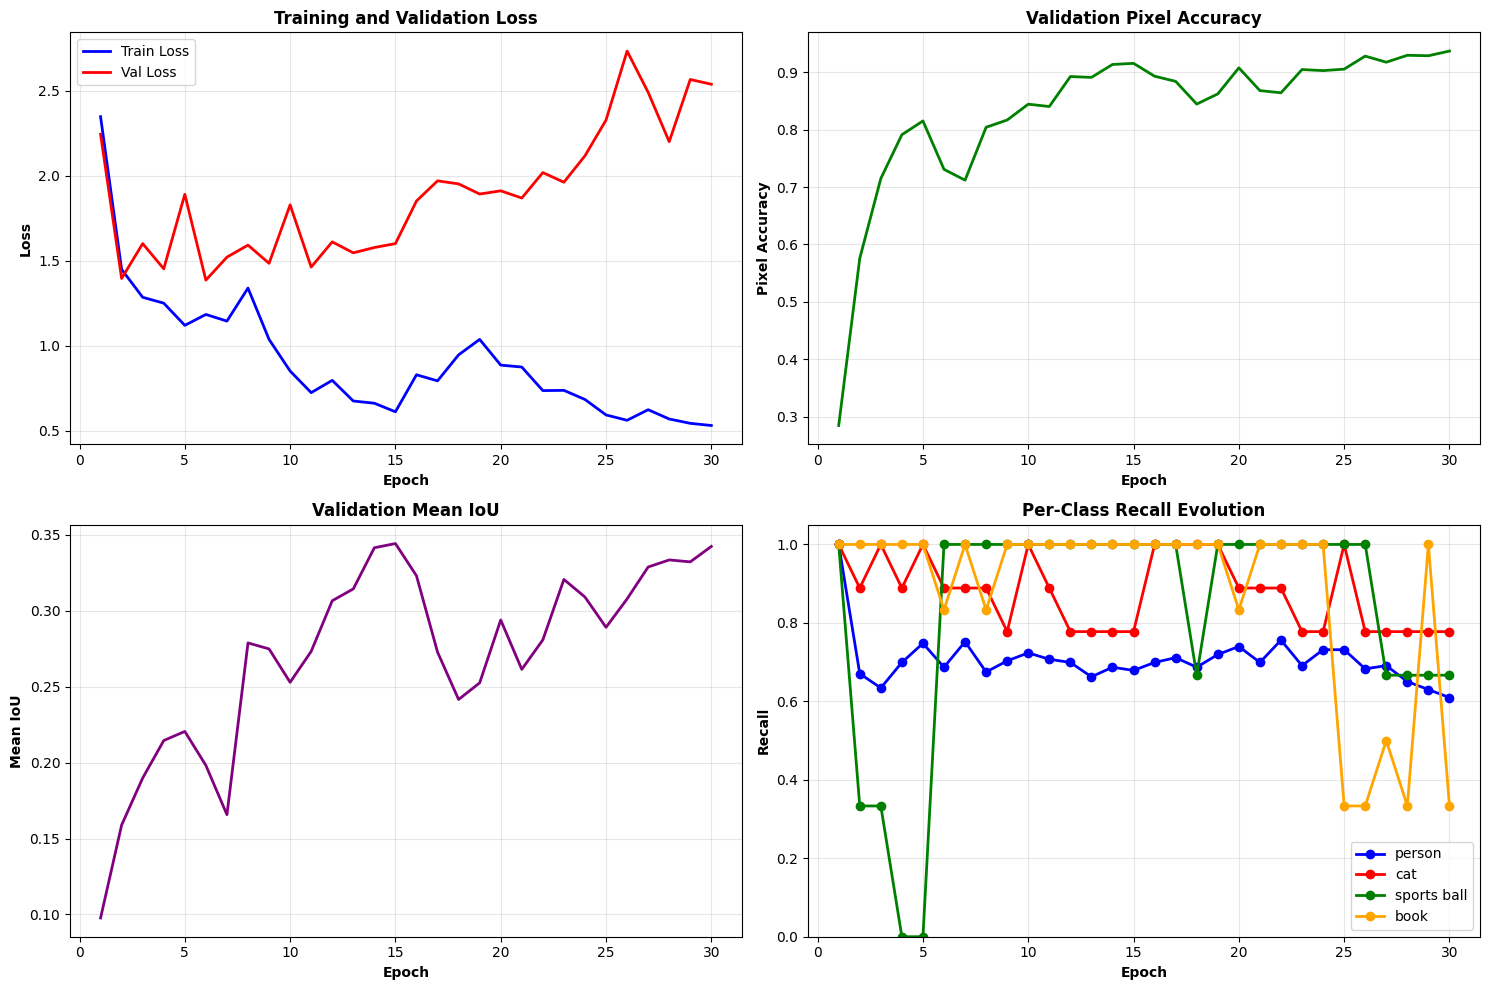

✓ Training history plotted


In [ ]:


def plot_deeplabv3_training_history(history):
    """Plot training curves for DeepLabV3+"""
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontweight='bold')
    axes[0, 0].set_ylabel('Loss', fontweight='bold')
    axes[0, 0].set_title('Training and Validation Loss', fontweight='bold', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Pixel Accuracy
    axes[0, 1].plot(epochs, history['val_pixel_accuracy'], 'g-', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontweight='bold')
    axes[0, 1].set_ylabel('Pixel Accuracy', fontweight='bold')
    axes[0, 1].set_title('Validation Pixel Accuracy', fontweight='bold', fontsize=12)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Mean IoU
    axes[1, 0].plot(epochs, history['val_mean_iou'], 'purple', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontweight='bold')
    axes[1, 0].set_ylabel('Mean IoU', fontweight='bold')
    axes[1, 0].set_title('Validation Mean IoU', fontweight='bold', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Per-class recall
    colors = {'person': 'blue', 'cat': 'red', 'sports ball': 'green', 'book': 'orange'}
    for class_name in config.CLASSES[1:]:
        recalls = history['per_class_recall'][class_name]
        axes[1, 1].plot(epochs, recalls, marker='o', label=class_name,
                       color=colors.get(class_name, 'gray'), linewidth=2)
    
    axes[1, 1].set_xlabel('Epoch', fontweight='bold')
    axes[1, 1].set_ylabel('Recall', fontweight='bold')
    axes[1, 1].set_title('Per-Class Recall Evolution', fontweight='bold', fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.savefig('deeplabv3_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_deeplabv3_training_history(history)


# MASK RCNN Model Training Loop

In [39]:


# Optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(
    params,
    lr=config.LEARNING_RATE,
    momentum=config.MOMENTUM,
    weight_decay=config.WEIGHT_DECAY
)

lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=config.STEP_SIZE,
    gamma=config.GAMMA
)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_loss_classifier': [],
    'train_loss_box_reg': [],
    'train_loss_mask': [],
    'val_loss_classifier': [],
    'val_loss_box_reg': [],
    'val_loss_mask': []
}

best_val_loss = float('inf')
patience = 5
patience_counter = 0

print("Starting training...")
print(f"Device: {device}")
print(f"Epochs: {config.NUM_EPOCHS}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Learning rate: {config.LEARNING_RATE}")
print("="*60)

for epoch in range(1, config.NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{config.NUM_EPOCHS}")
    print("-" * 60)

    # Train
    train_loss, train_loss_dict = train_one_epoch(
        model, optimizer, train_loader, device, epoch
    )

    # Validate
    val_loss, val_loss_dict = validate(model, val_loader, device)

    # Update scheduler
    lr_scheduler.step()

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_loss_classifier'].append(train_loss_dict['loss_classifier'])
    history['train_loss_box_reg'].append(train_loss_dict['loss_box_reg'])
    history['train_loss_mask'].append(train_loss_dict['loss_mask'])
    history['val_loss_classifier'].append(val_loss_dict['loss_classifier'])
    history['val_loss_box_reg'].append(val_loss_dict['loss_box_reg'])
    history['val_loss_mask'].append(val_loss_dict['loss_mask'])

    # Print epoch summary
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch} Summary:")
    print(f"Learning Rate: {current_lr:.6f}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"  - Classifier: {train_loss_dict['loss_classifier']:.4f}")
    print(f"  - Box Reg: {train_loss_dict['loss_box_reg']:.4f}")
    print(f"  - Mask: {train_loss_dict['loss_mask']:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"  - Classifier: {val_loss_dict['loss_classifier']:.4f}")
    print(f"  - Box Reg: {val_loss_dict['loss_box_reg']:.4f}")
    print(f"  - Mask: {val_loss_dict['loss_mask']:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'history': history
        }, 'best_model.pth')
        print(f"✓ Best model saved! (Val Loss: {val_loss:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s)")

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch} epochs")
        break

print("\n" + "="*60)
print("Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training...
Device: cuda
Epochs: 30
Batch size: 4
Learning rate: 0.002

Epoch 1/30
------------------------------------------------------------


Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validating: 100%|██████████| 75/75 [00:09<00:00,  7.94it/s]



Epoch 1 Summary:
Learning Rate: 0.002000
Train Loss: 1.2396
  - Classifier: 0.1874
  - Box Reg: 0.1686
  - Mask: 0.5450
Val Loss: 0.8964
  - Classifier: 0.1553
  - Box Reg: 0.2214
  - Mask: 0.3698
✓ Best model saved! (Val Loss: 0.8964)

Epoch 2/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.80it/s]



Epoch 2 Summary:
Learning Rate: 0.002000
Train Loss: 0.8907
  - Classifier: 0.1524
  - Box Reg: 0.1983
  - Mask: 0.3846
Val Loss: 0.7955
  - Classifier: 0.1458
  - Box Reg: 0.1877
  - Mask: 0.3418
✓ Best model saved! (Val Loss: 0.7955)

Epoch 3/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.28it/s]



Epoch 3 Summary:
Learning Rate: 0.002000
Train Loss: 0.8184
  - Classifier: 0.1440
  - Box Reg: 0.1829
  - Mask: 0.3522
Val Loss: 0.7714
  - Classifier: 0.1418
  - Box Reg: 0.1820
  - Mask: 0.3280
✓ Best model saved! (Val Loss: 0.7714)

Epoch 4/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.86it/s]



Epoch 4 Summary:
Learning Rate: 0.002000
Train Loss: 0.7673
  - Classifier: 0.1358
  - Box Reg: 0.1893
  - Mask: 0.3352
Val Loss: 0.7576
  - Classifier: 0.1288
  - Box Reg: 0.1919
  - Mask: 0.3232
✓ Best model saved! (Val Loss: 0.7576)

Epoch 5/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.15it/s]



Epoch 5 Summary:
Learning Rate: 0.002000
Train Loss: 0.7377
  - Classifier: 0.1235
  - Box Reg: 0.1767
  - Mask: 0.3290
Val Loss: 0.7436
  - Classifier: 0.1309
  - Box Reg: 0.1820
  - Mask: 0.3150
✓ Best model saved! (Val Loss: 0.7436)

Epoch 6/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.82it/s]



Epoch 6 Summary:
Learning Rate: 0.002000
Train Loss: 0.7085
  - Classifier: 0.1188
  - Box Reg: 0.1736
  - Mask: 0.3241
Val Loss: 0.7380
  - Classifier: 0.1224
  - Box Reg: 0.1785
  - Mask: 0.3178
✓ Best model saved! (Val Loss: 0.7380)

Epoch 7/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.79it/s]



Epoch 7 Summary:
Learning Rate: 0.002000
Train Loss: 0.7032
  - Classifier: 0.1179
  - Box Reg: 0.1735
  - Mask: 0.3159
Val Loss: 0.7217
  - Classifier: 0.1082
  - Box Reg: 0.1672
  - Mask: 0.3241
✓ Best model saved! (Val Loss: 0.7217)

Epoch 8/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.46it/s]



Epoch 8 Summary:
Learning Rate: 0.002000
Train Loss: 0.6846
  - Classifier: 0.1122
  - Box Reg: 0.1717
  - Mask: 0.3118
Val Loss: 0.7553
  - Classifier: 0.1240
  - Box Reg: 0.1884
  - Mask: 0.3148
No improvement for 1 epoch(s)

Epoch 9/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.54it/s]



Epoch 9 Summary:
Learning Rate: 0.002000
Train Loss: 0.6768
  - Classifier: 0.1174
  - Box Reg: 0.1698
  - Mask: 0.3025
Val Loss: 0.7361
  - Classifier: 0.1178
  - Box Reg: 0.1737
  - Mask: 0.3247
No improvement for 2 epoch(s)

Epoch 10/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.96it/s]



Epoch 10 Summary:
Learning Rate: 0.000600
Train Loss: 0.6712
  - Classifier: 0.1094
  - Box Reg: 0.1626
  - Mask: 0.3019
Val Loss: 0.7568
  - Classifier: 0.1255
  - Box Reg: 0.1823
  - Mask: 0.3296
No improvement for 3 epoch(s)

Epoch 11/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.89it/s]



Epoch 11 Summary:
Learning Rate: 0.000600
Train Loss: 0.6194
  - Classifier: 0.0982
  - Box Reg: 0.1505
  - Mask: 0.2929
Val Loss: 0.7169
  - Classifier: 0.1138
  - Box Reg: 0.1723
  - Mask: 0.3142
✓ Best model saved! (Val Loss: 0.7169)

Epoch 12/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.96it/s]



Epoch 12 Summary:
Learning Rate: 0.000600
Train Loss: 0.5889
  - Classifier: 0.0935
  - Box Reg: 0.1478
  - Mask: 0.2826
Val Loss: 0.7365
  - Classifier: 0.1185
  - Box Reg: 0.1782
  - Mask: 0.3155
No improvement for 1 epoch(s)

Epoch 13/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.71it/s]



Epoch 13 Summary:
Learning Rate: 0.000600
Train Loss: 0.5760
  - Classifier: 0.0919
  - Box Reg: 0.1466
  - Mask: 0.2775
Val Loss: 0.7367
  - Classifier: 0.1175
  - Box Reg: 0.1769
  - Mask: 0.3169
No improvement for 2 epoch(s)

Epoch 14/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:08<00:00,  8.38it/s]



Epoch 14 Summary:
Learning Rate: 0.000600
Train Loss: 0.5941
  - Classifier: 0.0950
  - Box Reg: 0.1505
  - Mask: 0.2834
Val Loss: 0.7208
  - Classifier: 0.1153
  - Box Reg: 0.1731
  - Mask: 0.3162
No improvement for 3 epoch(s)

Epoch 15/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.87it/s]



Epoch 15 Summary:
Learning Rate: 0.000600
Train Loss: 0.5643
  - Classifier: 0.0872
  - Box Reg: 0.1434
  - Mask: 0.2730
Val Loss: 0.7465
  - Classifier: 0.1212
  - Box Reg: 0.1744
  - Mask: 0.3157
No improvement for 4 epoch(s)

Epoch 16/30
------------------------------------------------------------


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.80it/s]



Epoch 16 Summary:
Learning Rate: 0.000600
Train Loss: 0.5764
  - Classifier: 0.0894
  - Box Reg: 0.1440
  - Mask: 0.2769
Val Loss: 0.7511
  - Classifier: 0.1222
  - Box Reg: 0.1756
  - Mask: 0.3162
No improvement for 5 epoch(s)

Early stopping triggered after 16 epochs

Training completed!
Best validation loss: 0.7169


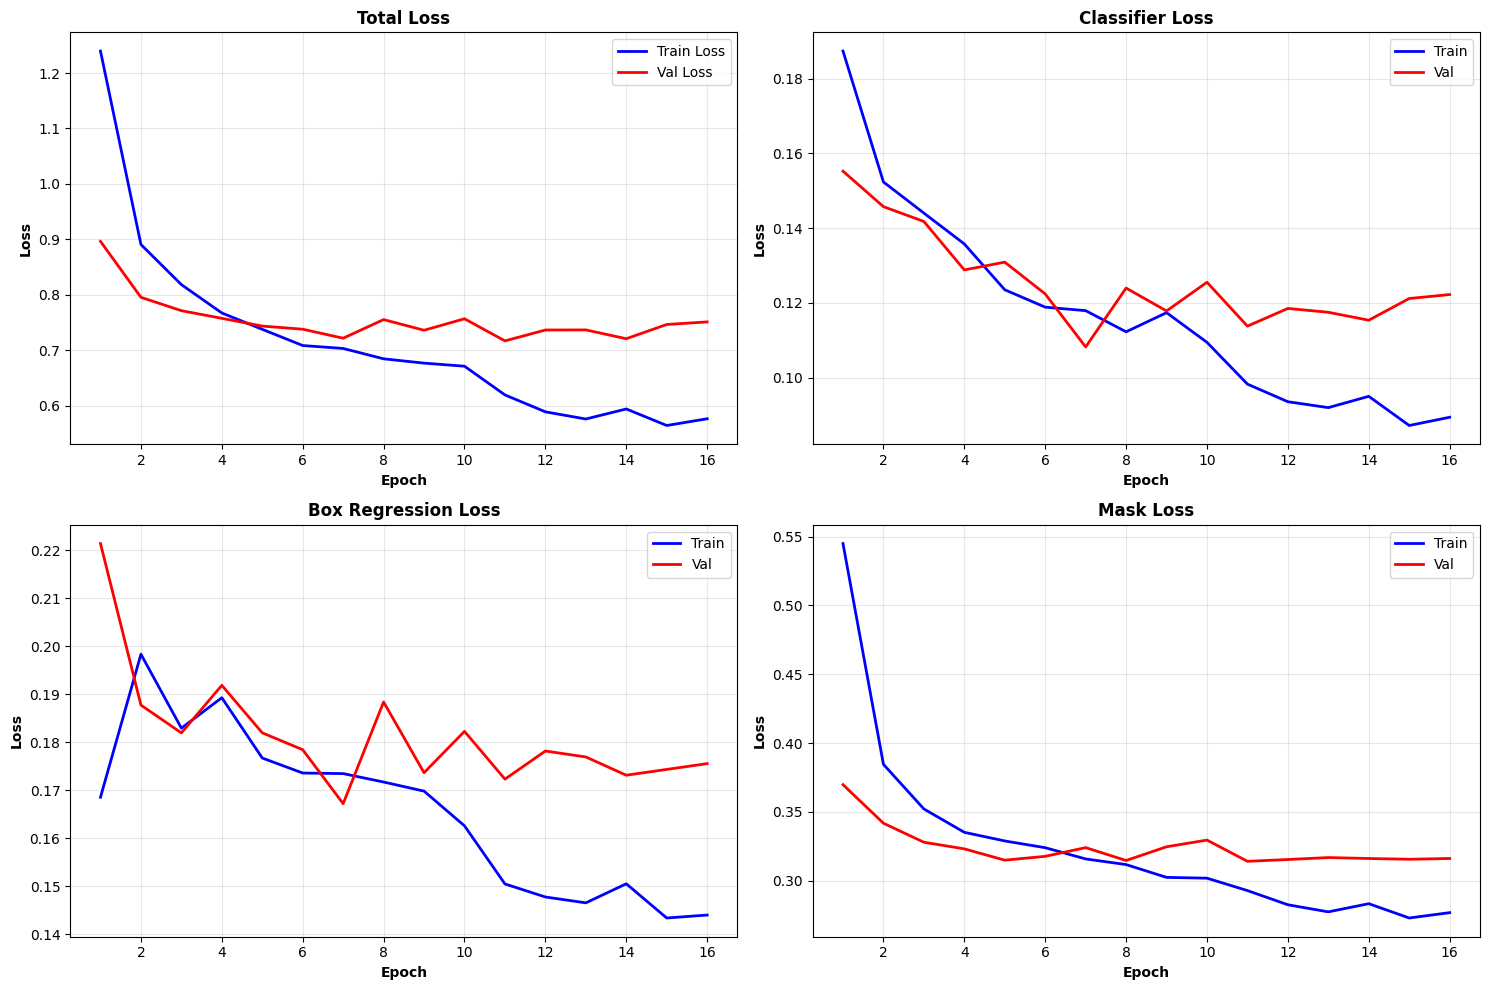

In [40]:


def plot_training_history(history):
    """Plot training curves"""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Total loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontweight='bold')
    axes[0, 0].set_ylabel('Loss', fontweight='bold')
    axes[0, 0].set_title('Total Loss', fontweight='bold', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Classifier loss
    axes[0, 1].plot(epochs, history['train_loss_classifier'], 'b-', label='Train', linewidth=2)
    axes[0, 1].plot(epochs, history['val_loss_classifier'], 'r-', label='Val', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontweight='bold')
    axes[0, 1].set_ylabel('Loss', fontweight='bold')
    axes[0, 1].set_title('Classifier Loss', fontweight='bold', fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Box regression loss
    axes[1, 0].plot(epochs, history['train_loss_box_reg'], 'b-', label='Train', linewidth=2)
    axes[1, 0].plot(epochs, history['val_loss_box_reg'], 'r-', label='Val', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontweight='bold')
    axes[1, 0].set_ylabel('Loss', fontweight='bold')
    axes[1, 0].set_title('Box Regression Loss', fontweight='bold', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Mask loss
    axes[1, 1].plot(epochs, history['train_loss_mask'], 'b-', label='Train', linewidth=2)
    axes[1, 1].plot(epochs, history['val_loss_mask'], 'r-', label='Val', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontweight='bold')
    axes[1, 1].set_ylabel('Loss', fontweight='bold')
    axes[1, 1].set_title('Mask Loss', fontweight='bold', fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(history)


In [41]:


# Load best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Best model loaded (Epoch {checkpoint['epoch']}, Val Loss: {checkpoint['val_loss']:.4f})")

Best model loaded (Epoch 11, Val Loss: 0.7169)


In [42]:

def calculate_iou(box1, box2):
    """Calculate IoU between two boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

def calculate_mask_iou(mask1, mask2):
    """Calculate IoU between two masks"""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

@torch.no_grad()
def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    """
    Evaluate model on validation set
    Returns precision, recall, F1, and mAP metrics
    """
    model.eval()

    all_predictions = []
    all_targets = []

    print("Running evaluation...")
    for images, targets in tqdm(data_loader):
        images = list(img.to(device) for img in images)

        # Get predictions
        predictions = model(images)

        # Move to CPU
        predictions = [{k: v.cpu() for k, v in pred.items()} for pred in predictions]
        targets = [{k: v.cpu() for k, v in t.items()} for t in targets]

        all_predictions.extend(predictions)
        all_targets.extend(targets)

    # Calculate metrics per class
    class_metrics = {}

    for class_id in range(1, config.NUM_CLASSES):
        class_name = config.CLASSES[class_id]

        tp = 0  # True positives
        fp = 0  # False positives
        fn = 0  # False negatives

        ious = []

        for pred, target in zip(all_predictions, all_targets):
            # Filter by class
            pred_mask = pred['labels'] == class_id
            target_mask = target['labels'] == class_id

            pred_boxes = pred['boxes'][pred_mask]
            pred_scores = pred['scores'][pred_mask]
            pred_masks = pred['masks'][pred_mask]

            target_boxes = target['boxes'][target_mask]
            target_masks = target['masks'][target_mask]

            # Apply score threshold
            score_mask = pred_scores > 0.5
            pred_boxes = pred_boxes[score_mask]
            pred_masks = pred_masks[score_mask]

            # Match predictions to targets
            matched_targets = set()

            for pred_box, pred_mask_tensor in zip(pred_boxes, pred_masks):
                pred_mask = pred_mask_tensor.squeeze().numpy() > 0.5
                best_iou = 0
                best_idx = -1

                for idx, (target_box, target_mask_tensor) in enumerate(zip(target_boxes, target_masks)):
                    if idx in matched_targets:
                        continue

                    target_mask = target_mask_tensor.squeeze().numpy()
                    mask_iou = calculate_mask_iou(pred_mask, target_mask)

                    if mask_iou > best_iou:
                        best_iou = mask_iou
                        best_idx = idx

                if best_iou >= iou_threshold:
                    tp += 1
                    matched_targets.add(best_idx)
                    ious.append(best_iou)
                else:
                    fp += 1

            fn += len(target_boxes) - len(matched_targets)

        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        avg_iou = np.mean(ious) if ious else 0

        class_metrics[class_name] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'avg_iou': avg_iou,
            'tp': tp,
            'fp': fp,
            'fn': fn
        }

    # Calculate overall metrics
    total_tp = sum(m['tp'] for m in class_metrics.values())
    total_fp = sum(m['fp'] for m in class_metrics.values())
    total_fn = sum(m['fn'] for m in class_metrics.values())

    overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

    overall_metrics = {
        'precision': overall_precision,
        'recall': overall_recall,
        'f1': overall_f1
    }

    return class_metrics, overall_metrics

# Run evaluation
class_metrics, overall_metrics = evaluate_model(model, val_loader, device, config.IOU_THRESHOLD)

# Print results
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

print(f"\nOverall Metrics (IoU threshold: {config.IOU_THRESHOLD}):")
print(f"  Precision: {overall_metrics['precision']:.4f}")
print(f"  Recall:    {overall_metrics['recall']:.4f}")
print(f"  F1 Score:  {overall_metrics['f1']:.4f}")

print(f"\nPer-Class Metrics:")
print("-"*60)
for class_name, metrics in class_metrics.items():
    print(f"\n{class_name}:")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1 Score:  {metrics['f1']:.4f}")
    print(f"  Avg IoU:   {metrics['avg_iou']:.4f}")
    print(f"  TP/FP/FN:  {metrics['tp']}/{metrics['fp']}/{metrics['fn']}")

Running evaluation...


100%|██████████| 75/75 [00:16<00:00,  4.56it/s]



EVALUATION RESULTS

Overall Metrics (IoU threshold: 0.5):
  Precision: 0.5115
  Recall:    0.6422
  F1 Score:  0.5694

Per-Class Metrics:
------------------------------------------------------------

person:
  Precision: 0.5335
  Recall:    0.7144
  F1 Score:  0.6108
  Avg IoU:   0.7598
  TP/FP/FN:  733/641/293

cat:
  Precision: 0.5000
  Recall:    0.6818
  F1 Score:  0.5769
  Avg IoU:   0.8099
  TP/FP/FN:  15/15/7

sports ball:
  Precision: 0.5600
  Recall:    0.3889
  F1 Score:  0.4590
  Avg IoU:   0.7966
  TP/FP/FN:  14/11/22

book:
  Precision: 0.1809
  Recall:    0.1318
  F1 Score:  0.1525
  Avg IoU:   0.6932
  TP/FP/FN:  17/77/112


In [43]:

def visualize_prediction(image, prediction, class_names, score_threshold=0.5, figsize=(12, 8)):
    """
    Visualize a single prediction

    Args:
        image: Input image tensor
        prediction: Model prediction dictionary
        class_names: List of class names
        score_threshold: Minimum score to display
        figsize: Figure size
    """
    # Convert image to numpy
    if isinstance(image, torch.Tensor):
        image = image.cpu().permute(1, 2, 0).numpy()
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(image)

    # Filter predictions by score
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    boxes = prediction['boxes'].cpu().numpy()
    masks = prediction['masks'].cpu().numpy()

    keep = scores >= score_threshold
    scores = scores[keep]
    labels = labels[keep]
    boxes = boxes[keep]
    masks = masks[keep]

    # Define colors for each class
    colors = ['red', 'blue', 'green', 'orange', 'purple']

    for score, label, box, mask in zip(scores, labels, boxes, masks):
        # Get class name and color
        class_name = class_names[label]
        color = colors[label % len(colors)]

        # Draw mask
        mask = mask[0] > 0.5
        colored_mask = np.zeros_like(image)
        colored_mask[mask] = np.array(plt.cm.get_cmap('tab10')(label % 10)[:3])
        ax.imshow(colored_mask, alpha=0.4)

        # Draw box
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                            fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

        # Add label
        label_text = f'{class_name}: {score:.2f}'
        ax.text(x1, y1-5, label_text,
               bbox=dict(facecolor=color, alpha=0.7),
               fontsize=10, color='white', weight='bold')

    ax.axis('off')
    ax.set_title(f'Predictions (threshold={score_threshold})',
                fontweight='bold', fontsize=14)

    plt.tight_layout()
    return fig

def compare_prediction_with_gt(image, prediction, target, class_names,
                               score_threshold=0.5, figsize=(16, 8)):
    """
    Compare prediction with ground truth side by side
    """
    # Convert image to numpy
    if isinstance(image, torch.Tensor):
        image = image.cpu().permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Ground truth
    axes[0].imshow(image)
    gt_labels = target['labels'].cpu().numpy()
    gt_boxes = target['boxes'].cpu().numpy()
    gt_masks = target['masks'].cpu().numpy()

    colors = ['red', 'blue', 'green', 'orange', 'purple']

    for label, box, mask in zip(gt_labels, gt_boxes, gt_masks):
        class_name = class_names[label]
        color = colors[label % len(colors)]

        mask = mask > 0.5
        colored_mask = np.zeros_like(image)
        colored_mask[mask] = np.array(plt.cm.get_cmap('tab10')(label % 10)[:3])
        axes[0].imshow(colored_mask, alpha=0.4)

        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                            fill=False, edgecolor=color, linewidth=2)
        axes[0].add_patch(rect)
        axes[0].text(x1, y1-5, class_name,
                    bbox=dict(facecolor=color, alpha=0.7),
                    fontsize=10, color='white', weight='bold')

    axes[0].axis('off')
    axes[0].set_title('Ground Truth', fontweight='bold', fontsize=14)

    # Prediction
    axes[1].imshow(image)

    scores = prediction['scores'].cpu().numpy()
    pred_labels = prediction['labels'].cpu().numpy()
    pred_boxes = prediction['boxes'].cpu().numpy()
    pred_masks = prediction['masks'].cpu().numpy()

    keep = scores >= score_threshold
    scores = scores[keep]
    pred_labels = pred_labels[keep]
    pred_boxes = pred_boxes[keep]
    pred_masks = pred_masks[keep]

    for score, label, box, mask in zip(scores, pred_labels, pred_boxes, pred_masks):
        class_name = class_names[label]
        color = colors[label % len(colors)]

        mask = mask[0] > 0.5
        colored_mask = np.zeros_like(image)
        colored_mask[mask] = np.array(plt.cm.get_cmap('tab10')(label % 10)[:3])
        axes[1].imshow(colored_mask, alpha=0.4)

        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                            fill=False, edgecolor=color, linewidth=2)
        axes[1].add_patch(rect)

        label_text = f'{class_name}: {score:.2f}'
        axes[1].text(x1, y1-5, label_text,
                    bbox=dict(facecolor=color, alpha=0.7),
                    fontsize=10, color='white', weight='bold')

    axes[1].axis('off')
    axes[1].set_title(f'Prediction (threshold={score_threshold})',
                     fontweight='bold', fontsize=14)

    plt.tight_layout()
    return fig



In [ ]:

model.eval()

num_samples = 3
sample_indices = np.random.choice(len(val_dataset), num_samples, replace=False)

print(f"Evaluating on {num_samples} validation samples...")

for idx in sample_indices:
    image, target = val_dataset[idx]

    # Get prediction
    with torch.no_grad():
        prediction = model([image.to(device)])[0]

    # Visualize
    fig = compare_prediction_with_gt(
        image, prediction, target, config.CLASSES,
        score_threshold=0.5, figsize=(16, 8)
    )
    plt.savefig(f'validation_sample_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistics
    pred_scores = prediction['scores'].cpu().numpy()
    pred_labels = prediction['labels'].cpu().numpy()
    keep = pred_scores >= 0.5

    print(f"\nSample {idx}:")
    print(f"  Ground truth objects: {len(target['labels'])}")
    print(f"  Predicted objects (score>0.5): {keep.sum()}")
    print(f"  GT classes: {[config.CLASSES[l] for l in target['labels'].tolist()]}")
    print(f"  Pred classes: {[config.CLASSES[l] for l in pred_labels[keep].tolist()]}")
    print("-"*60)

Evaluating on 3 validation samples...


In [ ]:
"""
Test on unlabeled test images
"""

def load_test_image(image_path, image_size=512):
    """Load and preprocess a test image"""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply same transforms as validation
    transform = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    transformed = transform(image=image)
    return transformed['image'], image

# Get test images
test_images = sorted([f for f in os.listdir(config.TEST_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))])
print(f"Found {len(test_images)} test images")

# Select 3 test images
num_test_samples = min(3, len(test_images))
selected_test_images = np.random.choice(test_images, num_test_samples, replace=False)

print(f"\nTesting on {num_test_samples} unlabeled images...")

model.eval()

for img_name in selected_test_images:
    img_path = os.path.join(config.TEST_DIR, img_name)

    # Load image
    image_tensor, original_image = load_test_image(img_path, config.IMAGE_SIZE)

    # Get prediction
    with torch.no_grad():
        prediction = model([image_tensor.to(device)])[0]

    # Visualize
    fig = visualize_prediction(
        image_tensor, prediction, config.CLASSES,
        score_threshold=0.5, figsize=(12, 8)
    )
    plt.savefig(f'test_prediction_{img_name}', dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistics
    pred_scores = prediction['scores'].cpu().numpy()
    pred_labels = prediction['labels'].cpu().numpy()
    keep = pred_scores >= 0.5

    print(f"\n{img_name}:")
    print(f"  Detected objects: {keep.sum()}")
    print(f"  Classes: {[config.CLASSES[l] for l in pred_labels[keep].tolist()]}")
    print(f"  Scores: {pred_scores[keep]}")
    print("-"*60)

Found 30 test images

Testing on 3 unlabeled images...


AttributeError: 'list' object has no attribute 'shape'

In [ ]:


def create_confusion_matrix(model, data_loader, device, class_names, iou_threshold=0.5):
    """Create confusion matrix for predictions"""
    model.eval()

    # Initialize confusion matrix
    num_classes = len(class_names) - 1  # Exclude background
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Creating confusion matrix"):
            images = list(img.to(device) for img in images)
            predictions = model(images)

            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes'].cpu().numpy()
                pred_labels = pred['labels'].cpu().numpy()
                pred_scores = pred['scores'].cpu().numpy()
                pred_masks = pred['masks'].cpu().numpy()

                target_boxes = target['boxes'].cpu().numpy()
                target_labels = target['labels'].cpu().numpy()
                target_masks = target['masks'].cpu().numpy()

                # Filter by score
                keep = pred_scores >= 0.5
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]
                pred_masks = pred_masks[keep]

                # Match predictions to targets
                matched_targets = set()

                for pred_box, pred_label, pred_mask_tensor in zip(pred_boxes, pred_labels, pred_masks):
                    pred_mask = pred_mask_tensor[0] > 0.5
                    best_iou = 0
                    best_target_label = None

                    for idx, (target_box, target_label, target_mask_tensor) in enumerate(
                        zip(target_boxes, target_labels, target_masks)):
                        if idx in matched_targets:
                            continue

                        target_mask = target_mask_tensor > 0.5
                        mask_iou = calculate_mask_iou(pred_mask, target_mask)

                        if mask_iou > best_iou:
                            best_iou = mask_iou
                            best_target_label = target_label

                    if best_iou >= iou_threshold and best_target_label is not None:
                        # True positive or misclassification
                        confusion_matrix[best_target_label-1, pred_label-1] += 1

    return confusion_matrix

# Create confusion matrix
cm = create_confusion_matrix(model, val_loader, device, config.CLASSES, config.IOU_THRESHOLD)

# Plot confusion matrix
class_names_no_bg = config.CLASSES[1:]  # Remove background

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_no_bg,
            yticklabels=class_names_no_bg,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Class', fontweight='bold', fontsize=12)
plt.ylabel('True Class', fontweight='bold', fontsize=12)
plt.title('Confusion Matrix (IoU≥0.5)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



Creating confusion matrix:   0%|          | 0/75 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
"""
Create comprehensive results summary
"""

# Create results DataFrame
results_data = []

for class_name, metrics in class_metrics.items():
    results_data.append({
        'Class': class_name,
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1-Score': f"{metrics['f1']:.4f}",
        'Avg IoU': f"{metrics['avg_iou']:.4f}",
        'True Positives': metrics['tp'],
        'False Positives': metrics['fp'],
        'False Negatives': metrics['fn']
    })

results_data.append({
    'Class': 'OVERALL',
    'Precision': f"{overall_metrics['precision']:.4f}",
    'Recall': f"{overall_metrics['recall']:.4f}",
    'F1-Score': f"{overall_metrics['f1']:.4f}",
    'Avg IoU': '-',
    'True Positives': sum(m['tp'] for m in class_metrics.values()),
    'False Positives': sum(m['fp'] for m in class_metrics.values()),
    'False Negatives': sum(m['fn'] for m in class_metrics.values())
})

results_df = pd.DataFrame(results_data)

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Save results to CSV
results_df.to_csv('evaluation_results.csv', index=False)
print("\n✓ Results saved to 'evaluation_results.csv'")

# Create a comprehensive report
report = f"""
IMAGE SEGMENTATION MODEL - EVALUATION REPORT
{'='*80}

CONFIGURATION:
- Model: Mask R-CNN with ResNet-50-FPN backbone
- Dataset: COCO 2017 subset (4 classes)
- Classes: {', '.join(config.CLASSES[1:])}
- Training images: {len(train_dataset)}
- Validation images: {len(val_dataset)}
- Image size: {config.IMAGE_SIZE}x{config.IMAGE_SIZE}
- Batch size: {config.BATCH_SIZE}
- Epochs trained: {len(history['train_loss'])}
- IoU threshold: {config.IOU_THRESHOLD}

OVERALL PERFORMANCE:
- Precision: {overall_metrics['precision']:.4f}
- Recall: {overall_metrics['recall']:.4f}
- F1-Score: {overall_metrics['f1']:.4f}

PER-CLASS PERFORMANCE:
"""

for class_name, metrics in class_metrics.items():
    report += f"\n{class_name}:\n"
    report += f"  Precision: {metrics['precision']:.4f}\n"
    report += f"  Recall: {metrics['recall']:.4f}\n"
    report += f"  F1-Score: {metrics['f1']:.4f}\n"
    report += f"  Avg IoU: {metrics['avg_iou']:.4f}\n"

report += f"\n{'='*80}\n"

# Save report
with open('evaluation_report.txt', 'w') as f:
    f.write(report)

print(report)
print("✓ Report saved to 'evaluation_report.txt'")

NameError: name 'class_metrics' is not defined

In [ ]:
|